# Beer type preferences

In [657]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Functions

In [424]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process['rating'] = (data_to_process['rating'] - data_to_process['rating'].mean()) / data_to_process['rating'].std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

In [425]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

## Loading and selecting data

In [426]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
print(df_ba.columns)
print(df_rb.columns)

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'review', 'user_location',
       'brewery_location', 'nbr_beers_by_brewery', 'zscore'],
      dtype='object')
Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text', 'user_location',
       'brewery_location', 'nbr_beers_by_brewery', 'zscore'],
      dtype='object')


In [477]:
df_ba_style = df_ba[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_rb_style = df_rb[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_styles_reviews = pd.concat([df_ba_style, df_rb_style]).reset_index().drop('index', axis=1).dropna()

# rephrase styles
old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
df_styles_reviews.replace(
    to_replace={'style':old_values},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'____'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'___'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews.replace(
    to_replace={'style':'__'},
    value='_',
    regex=True,
    inplace=True,
)
df_styles_reviews['style'] = df_styles_reviews['style'].str.strip('_')

print(df_styles_reviews['style'].unique())
print(len(df_styles_reviews))



['English_Brown_Ale' 'American_Double_Imperial_IPA' 'Weizenbock'
 'Russian_Imperial_Stout' 'American_IPA' 'Quadrupel_Quad' 'Wheatwine'
 'American_Pale_Ale_APA' 'Pumpkin_Ale' 'American_Amber_Red_Ale'
 'Euro_Pale_Lager' 'American_Double_Imperial_Stout' 'Fruit_Vegetable_Beer'
 'Tripel' 'Lambic_Fruit' 'Dortmunder_Export_Lager' 'Herbed_Spiced_Beer'
 'English_Barleywine' 'American_Porter' 'American_Adjunct_Lager'
 'Foreign_Export_Stout' 'Belgian_Pale_Ale' 'Rauchbier' 'American_Stout'
 'Flanders_Red_Ale' 'American_Strong_Ale' 'Altbier' 'Witbier'
 'California_Common_Steam_Beer' 'Schwarzbier' 'German_Pilsener'
 'Saison_Farmhouse_Ale' 'Dubbel' 'American_Malt_Liquor'
 'American_Black_Ale' 'American_Wild_Ale' 'Hefeweizen'
 'American_Brown_Ale' 'Flanders_Oud_Bruin' 'English_Strong_Ale'
 'English_India_Pale_Ale_IPA' 'Irish_Dry_Stout' 'Belgian_IPA'
 'Czech_Pilsener' 'Rye_Beer' 'Winter_Warmer' 'Belgian_Strong_Pale_Ale'
 'Märzen_Oktoberfest' 'Belgian_Strong_Dark_Ale' 'American_Pale_Wheat_Ale'
 'America

In [478]:
print(df_styles_reviews['brewery_location'].unique())
df_styles_reviews['brewery_location'] = df_styles_reviews['brewery_location'].str.replace("United States, ", "")
df_styles_reviews['user_location'] = df_styles_reviews['user_location'].str.replace("United States, ", "")
print(df_styles_reviews['brewery_location'].unique())

['United States, Wisconsin' 'United States, Illinois'
 'United States, Texas' 'Germany' 'United States, California' 'Belgium'
 'United States, Georgia' 'United States, New Jersey' 'Poland'
 'United States, Colorado' 'United States, Pennsylvania'
 'United States, New York' 'United States, Vermont' 'Canada'
 'United States, Wyoming' 'United States, Indiana'
 'United States, New Hampshire' 'Scotland' 'United States, Michigan'
 'United States, Maine' 'United States, Oregon'
 'United States, North Carolina' 'United States, Massachusetts'
 'United States, Minnesota' 'United States, Nevada'
 'United States, Rhode Island' 'United States, Florida' 'Mexico'
 'United States, Delaware' 'United States, Hawaii' 'England' 'Ireland'
 'United States, Washington' 'United States, Missouri'
 'United States, Ohio' 'Japan' 'United States, Alaska'
 'United States, Virginia' 'Costa Rica' 'United States, Oklahoma'
 'United States, Utah' 'Czech Republic' 'Denmark'
 'United States, Maryland' 'United States, Loui

### load categories

In [479]:
# load csv
df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')

# add category for each review
df_styles_reviews['category'] = "nothing"
for cat in df_styles_to_cat.columns:
    for style in df_styles_to_cat[cat].dropna():
        df_styles_reviews.loc[df_styles_reviews['style'] == style, 'category'] = cat

print(df_styles_reviews['category'].unique())

['BROWNS' 'PALE_ALES' 'WHEATS' 'STOUTS' 'BELGIANS' 'OTHER' 'SOURS'
 'LAGERS' 'PORTERS']


## Sorting by countries

In [507]:
user_loc_count = df_styles_reviews.groupby(['user_location'])['user_location'].count().sort_values(ascending=False)

# select 10 samples with the most reviews:
"""print(len(user_loc_count))
user_loc_count = user_loc_count[:10]"""
user_loc_count = user_loc_count[user_loc_count > 100]
print(user_loc_count)

user_location
California          94391
Pennsylvania        85412
Canada              77944
Illinois            70746
New York            62099
                    ...  
Philippines           133
Bolivia               132
Lesotho               121
Marshall Islands      108
Argentina             103
Name: user_location, Length: 119, dtype: int64


## Finding favourite category

In [533]:
df_cat_location_dumm = pd.get_dummies(df_styles_reviews, columns=['category'])
best_cat_per_user_location = {}

# remove special characters in columns names
#df_cat_location_dumm.columns = styles_rephrase(df_styles_location_dumm.columns)
df_cat_location_dumm.columns = df_cat_location_dumm.columns.str.replace('category_', '')

# transform boolean values to int values for linear regression
for col in df_cat_location_dumm.drop(['beer_id', 'beer_name', 'brewery_name', 'brewery_location','user_location', 'brewery_id', 'rating','style'], axis=1).columns:
    df_cat_location_dumm[col] = df_cat_location_dumm[col] * 1

# perform linear regression on each location
columns= list(df_cat_location_dumm.drop(['beer_id', 'beer_name', 'user_location', 'brewery_name', 'brewery_location', 'brewery_id', 'rating', 'style'], axis=1).columns)
for idx, loc in enumerate(list(user_loc_count.keys())):
    print(loc)
    df_reviews = df_cat_location_dumm[df_styles_reviews['user_location'] == loc]
    res = get_LR(df_reviews, columns)
    best_cat_per_user_location[loc] = res.params[res.params.keys() != 'Intercept'].sort_values(ascending=False)[0:3]
    print(best_cat_per_user_location[loc])

California
STOUTS       0.591949
SOURS        0.447969
PALE_ALES    0.380837
dtype: float64
Pennsylvania
STOUTS      0.540875
SOURS       0.453722
BELGIANS    0.374156
dtype: float64
Canada
STOUTS      0.454295
BELGIANS    0.379139
SOURS       0.377731
dtype: float64
Illinois
STOUTS       0.589677
SOURS        0.389470
PALE_ALES    0.339895
dtype: float64
New York
STOUTS      0.504115
SOURS       0.446456
BELGIANS    0.366715
dtype: float64
Denmark
SOURS      0.965848
STOUTS     0.864513
PORTERS    0.685149
dtype: float64
Texas
STOUTS     0.563816
PORTERS    0.357421
SOURS      0.336688
dtype: float64
England
SOURS       0.456419
STOUTS      0.452801
BELGIANS    0.367406
dtype: float64
Massachusetts
STOUTS       0.528037
SOURS        0.464210
PALE_ALES    0.369456
dtype: float64
Ohio
STOUTS      0.619405
SOURS       0.444840
BELGIANS    0.406285
dtype: float64
New Jersey
STOUTS      0.535452
SOURS       0.397465
BELGIANS    0.362396
dtype: float64
Florida
STOUTS      0.622934
SOURS    

## Finding most reviewed category

In [693]:
most_reviewed_cat_per_user_location = {}
for idx, loc in enumerate(list(user_loc_count.keys())):
    most_reviewed_cat_per_user_location[loc] = df_styles_reviews[df_styles_reviews['user_location']==loc].groupby(['category'])['category'].count().sort_values(ascending=False)[:3]
print(most_reviewed_cat_per_user_location)

{'California': category
PALE_ALES    42423
STOUTS       13903
BELGIANS      8149
Name: category, dtype: int64, 'Pennsylvania': category
PALE_ALES    37194
STOUTS       12565
LAGERS        7480
Name: category, dtype: int64, 'Canada': category
PALE_ALES    28129
OTHER         9691
LAGERS        9184
Name: category, dtype: int64, 'Illinois': category
PALE_ALES    30445
STOUTS       12420
OTHER         5832
Name: category, dtype: int64, 'New York': category
PALE_ALES    28281
STOUTS        8869
LAGERS        5202
Name: category, dtype: int64, 'Denmark': category
PALE_ALES    14439
LAGERS       10350
OTHER         7523
Name: category, dtype: int64, 'Texas': category
PALE_ALES    20651
STOUTS        7828
LAGERS        4916
Name: category, dtype: int64, 'England': category
PALE_ALES    24325
STOUTS        5084
LAGERS        4348
Name: category, dtype: int64, 'Massachusetts': category
PALE_ALES    22327
STOUTS        6507
LAGERS        3454
Name: category, dtype: int64, 'Ohio': category
PALE_A

## Finding local breweries

In [535]:
frac_reviews_per_brewery = {}

# loop on every location
for idx, loc in tqdm(enumerate(list(user_loc_count.keys())), total=len(list(user_loc_count.keys()))):

    # total number of reviews per brewery
    num_reviews_per_brewery = df_styles_reviews[df_styles_reviews['brewery_location'] == loc] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    # number of local reviews per brewery
    num_reviews_per_brewery_loc = df_styles_reviews[(df_styles_reviews['brewery_location'] == loc) & (df_styles_reviews['user_location'] == loc)] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)
    """print(len(num_reviews_per_brewery))
    print(len(num_reviews_per_brewery_loc))"""
    num_reviews_per_brewery.keys = num_reviews_per_brewery_loc.keys
    num_reviews_per_brewery = num_reviews_per_brewery.loc[num_reviews_per_brewery_loc.keys()]
    """print(len(num_reviews_per_brewery))
    print(num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False))
    print(num_reviews_per_brewery)
    print(num_reviews_per_brewery_loc)"""
    # fraction of local rewviews per brewery (90% and up)
    frac_reviews_per_brewery[loc] = num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False)
    frac_reviews_per_brewery[loc] = frac_reviews_per_brewery[loc][frac_reviews_per_brewery[loc].values > .5]
    

100%|██████████| 119/119 [00:22<00:00,  5.22it/s]


In [536]:
# removing the locations with no "local" breweries (meaning that there is no brewery with high enough fraction of local reviewers)
print(len(frac_reviews_per_brewery))
lst_empty_loc = []
for loc in frac_reviews_per_brewery:
    if len(frac_reviews_per_brewery[loc]) == 0:
        lst_empty_loc.append(loc)
print(lst_empty_loc)
for loc in lst_empty_loc:
    frac_reviews_per_brewery.pop(loc)
print(len(frac_reviews_per_brewery))
lst_locations = list(frac_reviews_per_brewery.keys())
print(lst_locations)

119
['North Dakota', 'Faroe Islands', 'Malaysia', 'Panama', 'El Salvador', 'Dominican Republic', 'Mozambique', 'Puerto Rico', 'Singapore', 'Cambodia', 'Bermuda', 'Lesotho', 'Marshall Islands']
106
['California', 'Pennsylvania', 'Canada', 'Illinois', 'New York', 'Denmark', 'Texas', 'England', 'Massachusetts', 'Ohio', 'New Jersey', 'Florida', 'Washington', 'Virginia', 'Minnesota', 'Michigan', 'Sweden', 'North Carolina', 'Colorado', 'Netherlands', 'Wisconsin', 'Maryland', 'Germany', 'Indiana', 'Norway', 'Georgia', 'Connecticut', 'Finland', 'Missouri', 'Oregon', 'Poland', 'Belgium', 'Australia', 'Arizona', 'New Hampshire', 'Kentucky', 'Tennessee', 'Scotland', 'Iowa', 'South Carolina', 'Kansas', 'Alabama', 'Spain', 'Vermont', 'Italy', 'Idaho', 'Maine', 'Estonia', 'Louisiana', 'Nevada', 'Rhode Island', 'Oklahoma', 'France', 'Delaware', 'Nebraska', 'Japan', 'Switzerland', 'Croatia', 'West Virginia', 'Israel', 'New Mexico', 'Slovak Republic', 'Arkansas', 'Czech Republic', 'New Zealand', 'Hunga

## Looking for each country if local breweries is answering to local preferences

### Get the global average representation of each style

In [537]:
retrain_glob_frac = False
if retrain_glob_frac:
    global_frac_per_cat = {}
    for cat in df_styles_reviews.category.unique():
        print(cat)
        global_frac_per_cat[cat] = 0
        for brewery in list(df_styles_reviews.brewery_name.unique()):
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat[cat] += val[0]
        global_frac_per_cat[cat] /= len(df_styles_reviews.brewery_name.unique())
    print(global_frac_per_cat)

In [538]:
global_frac_per_cat = {'BROWNS': 0.03483138963510579, 'PALE_ALES': 0.41155088541346874, 'WHEATS': 0.07872893800006803, 'STOUTS': 0.10731777909188722, 'BELGIANS': 0.05461235901529182, 'OTHER': 0.09424647167577703, 'SOURS': 0.013466836131315111, 'LAGERS': 0.15911566743367156, 'PORTERS': 0.046129673603413864}
print(global_frac_per_cat)

{'BROWNS': 0.03483138963510579, 'PALE_ALES': 0.41155088541346874, 'WHEATS': 0.07872893800006803, 'STOUTS': 0.10731777909188722, 'BELGIANS': 0.05461235901529182, 'OTHER': 0.09424647167577703, 'SOURS': 0.013466836131315111, 'LAGERS': 0.15911566743367156, 'PORTERS': 0.046129673603413864}


### Compare for each location

In [539]:
do_compare_loc = False
if do_compare_loc == True:
    # loop on every location
    frac_per_loc_per_cat = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()

        #styles = styles_rephrase(best_type_per_user_location[loc].keys())
        cats = best_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat[loc] = {}
        for cat in cats:

            frac_per_loc_per_cat[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)

100%|██████████| 106/106 [26:59<00:00, 15.28s/it] 


In [541]:
frac_per_loc_per_cat = {'California': {'STOUTS': 0.117035285879605, 'SOURS': 0.017912703249688106, 'PALE_ALES': 0.5646560706139874}, 'Pennsylvania': {'STOUTS': 0.12080384031733503, 'SOURS': 0.017730763205409988, 'BELGIANS': 0.05230919862505806}, 'Canada': {'STOUTS': 0.09366529138224722, 'BELGIANS': 0.03925869049928479, 'SOURS': 0.014048274345914498}, 'Illinois': {'STOUTS': 0.12718828163860543, 'SOURS': 0.017846673245060417, 'PALE_ALES': 0.4677590638033792}, 'New York': {'STOUTS': 0.10480291142013856, 'SOURS': 0.017489864749873227, 'BELGIANS': 0.032880680729820644}, 'Denmark': {'SOURS': 0.012503038447254915, 'STOUTS': 0.11068725816048124, 'PORTERS': 0.04356086728464482}, 'Texas': {'STOUTS': 0.15003011486660334, 'PORTERS': 0.07307764680822927, 'SOURS': 0.017825623803868693}, 'England': {'SOURS': 0.004834849615020088, 'STOUTS': 0.10305647546876606, 'BELGIANS': 0.007102407533712865}, 'Massachusetts': {'STOUTS': 0.08683606494797487, 'SOURS': 0.006052489177489177, 'PALE_ALES': 0.6502957800153937}, 'Ohio': {'STOUTS': 0.14655220775143113, 'SOURS': 0.01656136919791658, 'BELGIANS': 0.03907522690023981}, 'New Jersey': {'STOUTS': 0.14521355969127198, 'SOURS': 0.020572259813380955, 'BELGIANS': 0.018787635909548076}, 'Florida': {'STOUTS': 0.12637648465506637, 'SOURS': 0.014184082089535746, 'BELGIANS': 0.05158102382211658}, 'Washington': {'STOUTS': 0.10217037221066441, 'SOURS': 0.011374810221132983, 'BELGIANS': 0.05176064948406731}, 'Virginia': {'STOUTS': 0.13281081716070878, 'SOURS': 0.019405570969341025, 'BELGIANS': 0.037937656106223586}, 'Minnesota': {'STOUTS': 0.1366303397894, 'BELGIANS': 0.05771646901687924, 'SOURS': 0.011346078869738383}, 'Michigan': {'STOUTS': 0.19069466391890819, 'SOURS': 0.009352172141177716, 'BELGIANS': 0.038698194282980235}, 'Sweden': {'SOURS': 0.012850969643246961, 'STOUTS': 0.08526584555311034, 'PORTERS': 0.033875254220655036}, 'North Carolina': {'STOUTS': 0.13021816968368996, 'SOURS': 0.033720333875790105, 'BELGIANS': 0.032347382431055345}, 'Colorado': {'STOUTS': 0.14800853443095843, 'SOURS': 0.020710074865128, 'BELGIANS': 0.05859340234566776}, 'Netherlands': {'STOUTS': 0.12204955779443394, 'SOURS': 0.008782932830961612, 'PORTERS': 0.03959434404973238}, 'Wisconsin': {'STOUTS': 0.14922116291723656, 'SOURS': 0.007539757619275408, 'BELGIANS': 0.038458964501997074}, 'Maryland': {'STOUTS': 0.09246049016874876, 'BELGIANS': 0.04500867179085127, 'SOURS': 0.00825003279548734}, 'Germany': {'SOURS': 0.004084035267051732, 'STOUTS': 0.05057389392340355, 'BELGIANS': 0.007877009550934408}, 'Indiana': {'STOUTS': 0.14575311025848886, 'SOURS': 0.015631510245892145, 'BELGIANS': 0.024454400197615783}, 'Norway': {'STOUTS': 0.09087238844690539, 'SOURS': 0.009966925648439222, 'PORTERS': 0.047817378576565976}, 'Georgia': {'STOUTS': 0.11880437517106515, 'SOURS': 0.01153921702575637, 'BELGIANS': 0.05801520280060331}, 'Connecticut': {'STOUTS': 0.08271275234132179, 'SOURS': 0.004589100440280718, 'PALE_ALES': 0.7337699582192582}, 'Finland': {'STOUTS': 0.056802040294324896, 'SOURS': 0.007910015839597806, 'PORTERS': 0.055928181060659776}, 'Missouri': {'STOUTS': 0.18750886472016393, 'SOURS': 0.0, 'BELGIANS': 0.08413766794640218}, 'Oregon': {'STOUTS': 0.13855640980837558, 'SOURS': 0.05224154376696749, 'BELGIANS': 0.054386341132802773}, 'Poland': {'PORTERS': 0.05384321652180193, 'SOURS': 0.02708104367029991, 'STOUTS': 0.14170809014346175}, 'Belgium': {'STOUTS': 0.05360501206493872, 'SOURS': 0.004016064257028112, 'PALE_ALES': 0.15628166345033814}, 'Australia': {'STOUTS': 0.09730275443283944, 'SOURS': 0.009479061238985318, 'BELGIANS': 0.02126212582079547}, 'Arizona': {'STOUTS': 0.12414299612045514, 'SOURS': 0.020146154000320663, 'PORTERS': 0.08437079531645687}, 'New Hampshire': {'STOUTS': 0.15146292232149902, 'BELGIANS': 0.04028049922515996, 'PORTERS': 0.06283898152149697}, 'Kentucky': {'STOUTS': 0.09561891665012918, 'SOURS': 0.031259113087535026, 'BELGIANS': 0.017547206375737315}, 'Tennessee': {'STOUTS': 0.06762247279488659, 'SOURS': 0.004659832246039143, 'BELGIANS': 0.017978190391983496}, 'Scotland': {'STOUTS': 0.09631954824246264, 'SOURS': 0.010437625754527164, 'PORTERS': 0.04824498128993264}, 'Iowa': {'STOUTS': 0.05599547511312218, 'SOURS': 0.07692307692307693, 'BELGIANS': 0.11538461538461539}, 'South Carolina': {'STOUTS': 0.3238095238095238, 'BELGIANS': 0.0071428571428571435, 'SOURS': 0.0071428571428571435}, 'Kansas': {'STOUTS': 0.13314358001265023, 'SOURS': 0.00913978494623656, 'BELGIANS': 0.006045751633986928}, 'Alabama': {'STOUTS': 0.04352159468438538, 'BELGIANS': 0.07619047619047618, 'PORTERS': 0.12802721088435373}, 'Spain': {'STOUTS': 0.08798400827316948, 'BELGIANS': 0.06594261899337085, 'PORTERS': 0.023717053488061888}, 'Vermont': {'STOUTS': 0.05141155141155142, 'SOURS': 0.027777777777777776, 'PALE_ALES': 0.5157666407666407}, 'Italy': {'SOURS': 0.006241732804232804, 'STOUTS': 0.0798949032738095, 'BELGIANS': 0.12195522266978935}, 'Idaho': {'SOURS': 0.01680292904664223, 'STOUTS': 0.17961995415336307, 'BELGIANS': 0.015900024207172493}, 'Maine': {'BELGIANS': 0.0, 'STOUTS': 0.26666666666666666, 'SOURS': 0.0}, 'Estonia': {'STOUTS': 0.09592234449250958, 'PORTERS': 0.050934503455140244, 'BELGIANS': 0.0885187728937729}, 'Louisiana': {'STOUTS': 0.22312925170068024, 'SOURS': 0.0, 'PORTERS': 0.01020408163265306}, 'Nevada': {'STOUTS': 0.009523809523809523, 'SOURS': 0.03809523809523809, 'BELGIANS': 0.0857142857142857}, 'Rhode Island': {'SOURS': 0.0, 'STOUTS': 0.12244343891402716, 'PORTERS': 0.0}, 'Oklahoma': {'STOUTS': 0.2619047619047619, 'BELGIANS': 0.0, 'SOURS': 0.05555555555555555}, 'France': {'STOUTS': 0.0829563492063492, 'BELGIANS': 0.14358946608946607, 'PALE_ALES': 0.3752092352092352}, 'Delaware': {'STOUTS': 0.0, 'SOURS': 0.0, 'BELGIANS': 0.16666666666666666}, 'Nebraska': {'STOUTS': 0.159200195229607, 'BELGIANS': 0.0, 'PORTERS': 0.0920093795093795}, 'Japan': {'SOURS': 0.011380157713031046, 'STOUTS': 0.14943824470151842, 'PORTERS': 0.017585541256270334}, 'Switzerland': {'SOURS': 0.009241854636591478, 'STOUTS': 0.14537296073470096, 'BELGIANS': 0.058778379772961825}, 'Croatia': {'SOURS': 0.006144393241167435, 'BELGIANS': 0.03225806451612903, 'STOUTS': 0.10347716799329701}, 'West Virginia': {'STOUTS': 0.05600539811066127, 'BELGIANS': 0.05246288798920377, 'BROWNS': 0.0043859649122807015}, 'Israel': {'SOURS': 0.0, 'STOUTS': 0.1352846401718582, 'PORTERS': 0.03174603174603175}, 'New Mexico': {'SOURS': 0.0029411764705882353, 'STOUTS': 0.08630952380952381, 'BELGIANS': 0.017436974789915967}, 'Slovak Republic': {'SOURS': 0.002072102425876011, 'STOUTS': 0.07710412131107885, 'PORTERS': 0.02116932464809823}, 'Arkansas': {'STOUTS': 0.13888888888888887, 'BELGIANS': 0.0, 'PORTERS': 0.0}, 'Czech Republic': {'SOURS': 0.000851063829787234, 'BELGIANS': 0.004851063829787235, 'STOUTS': 0.06390070921985816}, 'New Zealand': {'STOUTS': 0.08682372764650284, 'SOURS': 0.03765236882011827, 'BELGIANS': 0.016751163047459345}, 'Hungary': {'BELGIANS': 0.014190821256038644, 'STOUTS': 0.09817363883117099, 'PORTERS': 0.04125494071146245}, 'Brazil': {'BELGIANS': 0.03531947295458085, 'PORTERS': 0.014350036310820624, 'STOUTS': 0.08818611724018315}, 'Mississippi': {'BELGIANS': 0.0, 'STOUTS': 0.15789473684210525, 'PORTERS': 0.0}, 'Alaska': {'STOUTS': 0.1851684263448969, 'PORTERS': 0.053318250377073904, 'BELGIANS': 0.06079688285570639}, 'Romania': {'STOUTS': 0.10050505050505049, 'SOURS': 0.0, 'PORTERS': 0.02954545454545454}, 'Utah': {'STOUTS': 0.0, 'SOURS': 0.0, 'PORTERS': 0.010416666666666666}, 'Ireland': {'BELGIANS': 0.009090909090909092, 'STOUTS': 0.2518939393939394, 'PORTERS': 0.07597402597402597}, 'Russia': {'BELGIANS': 0.014529984449807357, 'PORTERS': 0.02586784413288074, 'STOUTS': 0.1383783118000358}, 'Austria': {'SOURS': 0.015625, 'STOUTS': 0.11328749375624375, 'BELGIANS': 0.013257575757575756}, 'Thailand': {'STOUTS': 0.0, 'BROWNS': 0.0, 'PORTERS': 0.0}, 'Mexico': {'BELGIANS': 0.015360983102918587, 'SOURS': 0.016129032258064516, 'STOUTS': 0.19751498934641493}, 'South Dakota': {'BELGIANS': 0.013888888888888888, 'STOUTS': 0.2037037037037037, 'PORTERS': 0.037037037037037035}, 'Montana': {'STOUTS': 0.175, 'PORTERS': 0.0, 'SOURS': 0.0}, 'Wyoming': {'SOURS': 0.0, 'STOUTS': 0.16527777777777777, 'BELGIANS': 0.03333333333333333}, 'Slovenia': {'BELGIANS': 0.0641025641025641, 'BROWNS': 0.027125506072874492, 'PORTERS': 0.05975629118043979}, 'Greece': {'STOUTS': 0.0673076923076923, 'SOURS': 0.0, 'PORTERS': 0.0}, 'Hawaii': {'STOUTS': 0.3333333333333333, 'SOURS': 0.0, 'PORTERS': 0.0}, 'Portugal': {'PORTERS': 0.14761904761904762, 'SOURS': 0.0, 'STOUTS': 0.15}, 'Northern Ireland': {'BELGIANS': 0.3333333333333333, 'PORTERS': 0.0, 'STOUTS': 0.3333333333333333}, 'Belarus': {'BELGIANS': 0.0163265306122449, 'PORTERS': 0.020634920634920634, 'STOUTS': 0.1918006596578025}, 'Hong Kong': {'SOURS': 0.0, 'STOUTS': 0.06666666666666667, 'BELGIANS': 0.2}, 'Latvia': {'STOUTS': 0.0, 'BROWNS': 0.0, 'SOURS': 0.0}, 'Serbia': {'BELGIANS': 0.0, 'SOURS': 0.0, 'STOUTS': 0.0}, 'South Africa': {'STOUTS': 0.09828001375988991, 'BELGIANS': 0.036549707602339186, 'SOURS': 0.0}, 'Ukraine': {'SOURS': 0.005555555555555556, 'STOUTS': 0.0, 'BROWNS': 0.05555555555555555}, 'Moldova': {'BROWNS': 0.0, 'STOUTS': 0.08333333333333333, 'PORTERS': 0.0}, 'Turkey': {'BELGIANS': 0.0, 'STOUTS': 0.0, 'BROWNS': 0.0}, 'Lithuania': {'SOURS': 0.0, 'BELGIANS': 0.04444444444444444, 'PORTERS': 0.01111111111111111}, 'Taiwan': {'BELGIANS': 0.0, 'STOUTS': 0.0, 'BROWNS': 0.0}, 'Chile': {'BELGIANS': 0.015873015873015872, 'SOURS': 0.0, 'STOUTS': 0.10582010582010583}, 'China': {'BELGIANS': 0.0, 'BROWNS': 0.5, 'SOURS': 0.0}, 'Iceland': {'STOUTS': 0.75, 'BELGIANS': 0.0, 'SOURS': 0.0}, 'Venezuela': {'SOURS': 0.0, 'PORTERS': 0.0, 'STOUTS': 0.0}, 'Luxembourg': {'SOURS': 0.0, 'STOUTS': 0.0, 'BELGIANS': 0.0}, 'Cyprus': {'STOUTS': 0.0, 'PORTERS': 0.0, 'SOURS': 0.0}, 'Wales': {'SOURS': 0.0, 'BELGIANS': 0.0, 'BROWNS': 0.0}, 'India': {'BELGIANS': 0.0, 'PORTERS': 0.0, 'STOUTS': 0.0}, 'Jersey': {'PORTERS': 0.0, 'BELGIANS': 0.0, 'BROWNS': 0.0}, 'Philippines': {'BELGIANS': 0.0, 'STOUTS': 0.06666666666666667, 'PORTERS': 0.0}, 'Bolivia': {'BELGIANS': 0.0, 'PALE_ALES': 1.0, 'STOUTS': 0.0}, 'Argentina': {'STOUTS': 0.0, 'BELGIANS': 0.3333333333333333, 'PORTERS': 0.0}}

print(frac_per_loc_per_cat)

{'California': {'STOUTS': 0.117035285879605, 'SOURS': 0.017912703249688106, 'PALE_ALES': 0.5646560706139874}, 'Pennsylvania': {'STOUTS': 0.12080384031733503, 'SOURS': 0.017730763205409988, 'BELGIANS': 0.05230919862505806}, 'Canada': {'STOUTS': 0.09366529138224722, 'BELGIANS': 0.03925869049928479, 'SOURS': 0.014048274345914498}, 'Illinois': {'STOUTS': 0.12718828163860543, 'SOURS': 0.017846673245060417, 'PALE_ALES': 0.4677590638033792}, 'New York': {'STOUTS': 0.10480291142013856, 'SOURS': 0.017489864749873227, 'BELGIANS': 0.032880680729820644}, 'Denmark': {'SOURS': 0.012503038447254915, 'STOUTS': 0.11068725816048124, 'PORTERS': 0.04356086728464482}, 'Texas': {'STOUTS': 0.15003011486660334, 'PORTERS': 0.07307764680822927, 'SOURS': 0.017825623803868693}, 'England': {'SOURS': 0.004834849615020088, 'STOUTS': 0.10305647546876606, 'BELGIANS': 0.007102407533712865}, 'Massachusetts': {'STOUTS': 0.08683606494797487, 'SOURS': 0.006052489177489177, 'PALE_ALES': 0.6502957800153937}, 'Ohio': {'STOUTS

In [542]:
diff_frac_per_loc_per_cat = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat[loc] = {}
    print(loc)
    for cat in frac_per_loc_per_cat[loc]:
        print(cat)
        diff_frac_per_loc_per_cat[loc][cat] = frac_per_loc_per_cat[loc][cat] - global_frac_per_cat[cat]

California
STOUTS
SOURS
PALE_ALES
Pennsylvania
STOUTS
SOURS
BELGIANS
Canada
STOUTS
BELGIANS
SOURS
Illinois
STOUTS
SOURS
PALE_ALES
New York
STOUTS
SOURS
BELGIANS
Denmark
SOURS
STOUTS
PORTERS
Texas
STOUTS
PORTERS
SOURS
England
SOURS
STOUTS
BELGIANS
Massachusetts
STOUTS
SOURS
PALE_ALES
Ohio
STOUTS
SOURS
BELGIANS
New Jersey
STOUTS
SOURS
BELGIANS
Florida
STOUTS
SOURS
BELGIANS
Washington
STOUTS
SOURS
BELGIANS
Virginia
STOUTS
SOURS
BELGIANS
Minnesota
STOUTS
BELGIANS
SOURS
Michigan
STOUTS
SOURS
BELGIANS
Sweden
SOURS
STOUTS
PORTERS
North Carolina
STOUTS
SOURS
BELGIANS
Colorado
STOUTS
SOURS
BELGIANS
Netherlands
STOUTS
SOURS
PORTERS
Wisconsin
STOUTS
SOURS
BELGIANS
Maryland
STOUTS
BELGIANS
SOURS
Germany
SOURS
STOUTS
BELGIANS
Indiana
STOUTS
SOURS
BELGIANS
Norway
STOUTS
SOURS
PORTERS
Georgia
STOUTS
SOURS
BELGIANS
Connecticut
STOUTS
SOURS
PALE_ALES
Finland
STOUTS
SOURS
PORTERS
Missouri
STOUTS
SOURS
BELGIANS
Oregon
STOUTS
SOURS
BELGIANS
Poland
PORTERS
SOURS
STOUTS
Belgium
STOUTS
SOURS
PALE_ALES
Austra

In [694]:
"""for loc in lst_locations:
    print(loc)
    mean_deviation = 0
    for cat in diff_frac_per_loc_per_cat[loc]:
        mean_deviation += diff_frac_per_loc_per_cat[loc][cat]
        print(diff_frac_per_loc_per_cat[loc][cat])
    print(mean_deviation/3)
    #print(diff_frac_per_loc_per_cat[loc])
#print(diff_frac_per_loc_per_cat)"""

'for loc in lst_locations:\n    print(loc)\n    mean_deviation = 0\n    for cat in diff_frac_per_loc_per_cat[loc]:\n        mean_deviation += diff_frac_per_loc_per_cat[loc][cat]\n        print(diff_frac_per_loc_per_cat[loc][cat])\n    print(mean_deviation/3)\n    #print(diff_frac_per_loc_per_cat[loc])\n#print(diff_frac_per_loc_per_cat)'

## Looking for each country if local breweries is answering to most reviewed

### Compare for each location

In [696]:
do_compare_loc_2 = True
if do_compare_loc_2 == True:
    # loop on every location
    frac_per_loc_per_cat_2 = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()

        #styles = styles_rephrase(best_type_per_user_location[loc].keys())
        cats = most_reviewed_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat_2[loc] = {}
        for cat in cats:

            frac_per_loc_per_cat_2[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat_2[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat_2[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)

100%|██████████| 106/106 [27:35<00:00, 15.62s/it] 


In [699]:
diff_frac_per_loc_per_cat_ana2 = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat_ana2[loc] = {}
    print(loc)
    for cat in frac_per_loc_per_cat_2[loc]:
        print(cat)
        diff_frac_per_loc_per_cat_ana2[loc][cat] = frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat[cat]

California
PALE_ALES
STOUTS
BELGIANS
Pennsylvania
PALE_ALES
STOUTS
LAGERS
Canada
PALE_ALES
OTHER
LAGERS
Illinois
PALE_ALES
STOUTS
OTHER
New York
PALE_ALES
STOUTS
LAGERS
Denmark
PALE_ALES
LAGERS
OTHER
Texas
PALE_ALES
STOUTS
LAGERS
England
PALE_ALES
STOUTS
LAGERS
Massachusetts
PALE_ALES
STOUTS
LAGERS
Ohio
PALE_ALES
STOUTS
OTHER
New Jersey
PALE_ALES
STOUTS
OTHER
Florida
PALE_ALES
STOUTS
OTHER
Washington
PALE_ALES
STOUTS
OTHER
Virginia
PALE_ALES
STOUTS
LAGERS
Minnesota
PALE_ALES
STOUTS
LAGERS
Michigan
PALE_ALES
STOUTS
OTHER
Sweden
PALE_ALES
LAGERS
OTHER
North Carolina
PALE_ALES
STOUTS
OTHER
Colorado
PALE_ALES
STOUTS
OTHER
Netherlands
BELGIANS
PALE_ALES
STOUTS
Wisconsin
PALE_ALES
STOUTS
LAGERS
Maryland
PALE_ALES
STOUTS
BELGIANS
Germany
LAGERS
PALE_ALES
WHEATS
Indiana
PALE_ALES
STOUTS
LAGERS
Norway
PALE_ALES
LAGERS
OTHER
Georgia
PALE_ALES
STOUTS
LAGERS
Connecticut
PALE_ALES
STOUTS
OTHER
Finland
PALE_ALES
LAGERS
OTHER
Missouri
PALE_ALES
STOUTS
LAGERS
Oregon
PALE_ALES
STOUTS
OTHER
Poland
PALE_

## Show results

## Load and merge shapefiles

In [544]:
# Load shapefiles
world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')

# clean world
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

# clean states
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

# concatenate
shapefile = pd.concat([world_clean, states_clean], axis=0)

C:\Users\swann\AppData\Local\Temp\ipykernel_24276\3631237360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)


## Show main category per location

In [600]:
sf_maincat = shapefile.copy()
sf_maincat['main_cat'] = "None"
for loc in lst_locations:
    sf_maincat.loc[sf_maincat['name'] == loc, 'main_cat'] = best_cat_per_user_location[loc].keys()[0]

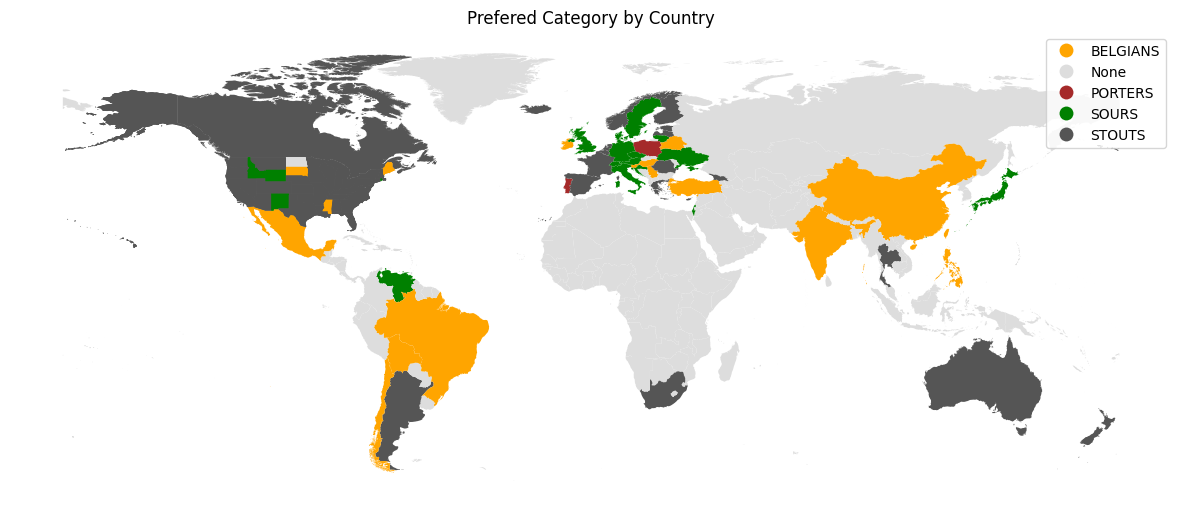

In [697]:
# color map
color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
#sf_maincat.plot(column='main_cat', ax=ax, legend=True)
plt.title('Prefered Category by Country')
plt.axis('off')
plt.savefig('../results/map_pref_cat.png')
plt.show()

## Show how breweries adapt to local preferences

In [668]:
sf_local_breweries = shapefile.copy()
sf_local_breweries['diff'] = 0
for loc in lst_locations:
    #print(diff_frac_per_loc_per_cat[loc][next(iter(diff_frac_per_loc_per_cat[loc]))])
    #print(best_cat_per_user_location[loc].keys())
    print(list(diff_frac_per_loc_per_cat[loc].values()))
    print(np.sum(np.asarray(list(diff_frac_per_loc_per_cat[loc].values())))/3)
    #sf_local_breweries.loc[sf_local_breweries['name'] == loc, 'diff'] = diff_frac_per_loc_per_cat[loc][next(iter(diff_frac_per_loc_per_cat[loc]))]
    sf_local_breweries.loc[sf_local_breweries['name'] == loc, 'diff'] = np.sum(np.asarray(list(diff_frac_per_loc_per_cat[loc].values())))/3

[0.00971750678771778, 0.004445867118372995, 0.15310518520051863]
0.0557561863688698
[0.013486061225447807, 0.004263927074094877, -0.0023031603902337605]
0.005148942636436307
[-0.013652487709640004, -0.01535366851600703, 0.000581438214599387]
-0.009474906003682549
[0.01987050254671821, 0.004379837113745306, 0.05620817838991049]
0.026819506016791336
[-0.0025148676717486607, 0.004023028618558116, -0.02173167828547118]
-0.0067411724462205745
[-0.0009637976840601963, 0.003369479068594014, -0.0025688063187690457]
-5.4374978078409325e-05
[0.042712335774716115, 0.026947973204815408, 0.004358787672553582]
0.0246730322173617
[-0.008631986516295022, -0.00426130362312116, -0.04750995148157896]
-0.020134413873665047
[-0.020481714143912352, -0.007414346953825934, 0.23874489460192494]
0.07028294450139555
[0.03923442865954391, 0.0030945330666014674, -0.015537132115052012]
0.008930609870364455
[0.037895780599384754, 0.007105423682065844, -0.03582472310574375]
0.0030588270585689505
[0.01905870556317915,

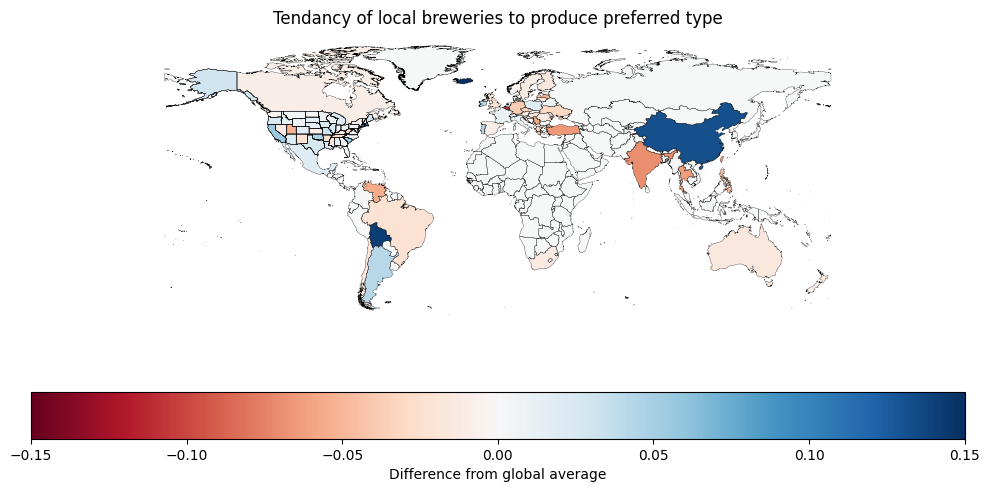

In [710]:
# color map
#color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
#sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
#_ =shiftedColorMap(plt.get_cmap('seismic'), -0.1, 0.28, 0.6, name='test_2')

sf_local_breweries.plot(column='diff', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Difference from global average", "orientation": "horizontal"}, vmin=-0.15, vmax=0.15)
#cbar=m.colorbar(location="bottom")
"""divnorm=colors.TwoSlopeNorm(vmin=-0.1, vcenter=0., vmax=0.6)
pcolormesh(your_data, cmap="coolwarm", norm=divnorm)"""
#pcm = ax.pcolormesh(sf_local_breweries, vmin=-1., vmax=1., cmap='RdBu_r')
plt.title('Tendancy of local breweries to produce preferred type')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/map_local_breweries.png')
plt.show()

In [ ]:
lst_names = ['Northern Mariana Islands', 'Kuril Islands', 'France', 'Serbia', 'Uruguay', 'Guam', 'Panama', 'Netherlands Antilles', 'Algeria', 'Togo', "Ma'tan al-Sarra", 'Switzerland', 'Jersey', 'Austria', 'Portugal', 'Luxembourg', 'Kazakhstan', 'Aruba', 'Holy See', 'Equatorial Guinea', 'Jamaica', 'Estonia', 'Niger', 'Belize', 'Morocco', 'Malta', 'Finland', 'Turkey', 'Lithuania', 'Russian Federation', 'Zimbabwe', 'Singapore', 'Oman', 'Republic of Korea', 'Montserrat', 'Liberia', 'Rwanda', 'Nicaragua', 'Mozambique', 'Mayotte', 'Cameroon', 'Hong Kong', 'Yemen', 'Western Sahara', 'Tokelau', 'Grenada', 'Cayman Islands', 'Dominican Republic', 'Argentina', 'Congo', 'Bahamas', 'Chile', 'Guinea', 'British Indian Ocean Territory', 'Saint Kitts and Nevis', 'Solomon Islands', 'Pitcairn Island', 'Saint Lucia', 'Turkmenistan', 'French Southern and Antarctic Territories', 'Slovenia', 'El Salvador', 'Cook Islands', 'Uganda', 'Uzbekistan', 'Ireland', 'Eritrea', 'Kuwait', 'Brunei Darussalam', 'Cape Verde', 'Italy', 'Iran (Islamic Republic of)', 'United Arab Emirates', 'British Virgin Islands', 'San Marino', 'Zambia', 'Latvia', 'Marshall Islands', 'Syrian Arab Republic', 'Sri Lanka', 'Glorioso Islands', 'Paracel Islands', 'Guernsey', 'Palau', 'Canada', 'Ethiopia', 'Greenland', 'Comoros', 'Abyei', 'Guatemala', 'Kyrgyzstan', 'Suriname', 'Poland', 'Ilemi Triangle', 'Spratly Islands', 'Bermuda', 'Arunachal Pradesh', 'South Sudan', 'Bulgaria', 'U.K. of Great Britain and Northern Ireland', 'Bahrain', 'Niue', 'Somalia', 'Barbados', 'Puerto Rico', 'Seychelles', 'Senegal', 'Greece', 'West Bank', 'Guantanamo', 'Costa Rica', 'Indonesia', 'Liechtenstein', 'Kiribati', 'Fiji', 'Malawi', 'Nigeria', 'Norfolk Island', 'Aksai Chin', 'Monaco', 'Gambia', 'Timor-Leste', 'Honduras', 'Botswana', 'Burkina Faso', 'Ukraine', 'Swaziland', 'New Caledonia', 'Falkland Islands (Malvinas)', 'Pakistan', 'South Africa', "Democratic People's Republic of Korea", 'Maldives', 'Lebanon', 'Christmas Island', 'United States Virgin Islands', 'Faroe Islands', 'Lesotho', 'Tajikistan', 'Burundi', 'Philippines', 'Madagascar', 'Azerbaijan', 'Mauritania', 'Egypt', 'Germany', "Côte d'Ivoire", 'India', 'Venezuela', 'Bhutan', 'Sierra Leone', 'Tonga', 'Dominica', 'Bosnia & Herzegovina', 'Jordan', 'Qatar', 'Tuvalu', 'Saint Vincent and the Grenadines', 'Gaza Strip', 'Jarvis Island', 'Montenegro', 'Svalbard and Jan Mayen Islands', 'Vietnam', 'Croatia', 'Isle of Man', 'Iceland', 'Namibia', 'Moldova, Republic of', 'Nauru', 'Thailand', 'Nepal', 'American Samoa', 'Andorra', 'Australia', 'Bouvet Island', 'The former Yugoslav Republic of Macedonia', 'Peru', 'Benin', 'Paraguay', 'Midway Is.', 'Reunion', 'Saudi Arabia', 'Taiwan', 'Guadeloupe', 'Central African Republic', 'French Polynesia', 'Azores Islands', 'Brazil', 'Haiti', 'Hungary', 'Djibouti', 'Vanuatu', 'Cambodia', 'Georgia', 'South Georgia & the South Sandwich Islands', 'Mongolia', 'Spain', 'Cyprus', 'Macao', 'Jammu-Kashmir', 'Heard Island and McDonald Islands', 'French Guiana', 'Democratic Republic of the Congo', 'Guinea-Bissau', 'Papua New Guinea', 'Turks and Caicos Islands', 'Bolivia', 'Cuba', 'China', 'Iraq', 'Martinique', 'Malaysia', 'Sweden', 'Ghana', 'Angola', 'Antigua & Barbuda', 'Norway', 'Bangladesh', 'Denmark', 'Belgium', 'Samoa', 'Anguilla', 'Israel', 'Libyan Arab Jamahiriya', 'Mexico', 'Romania', 'Belarus', 'Ecuador', 'Sudan', 'United Republic of Tanzania', 'Micronesia (Federated States of)', "Hala'ib Triangle", 'Myanmar', 'Mauritius', 'Cocos (Keeling) Islands', 'Afghanistan', 'Sao Tome and Principe', 'Colombia', 'Czech Republic', 'Japan', "Lao People's Democratic Republic", 'Tunisia', 'Guyana', 'Gabon', 'Netherlands', 'Chad', 'Trinidad and Tobago', 'Slovakia', 'Mali', 'Armenia', 'Albania', 'Gibraltar', 'New Zealand', 'Madeira Islands', 'Kenya', "['North Dakota']", "['Alaska']", "['Washington']", "['New Mexico']", "['Massachusetts']", "['Utah']", "['Oregon']", "['Mississippi']", "['Kentucky']", "['Idaho']", "['Maine']", "['Iowa']", "['Oklahoma']", "['Arkansas']", "['Wisconsin']", "['Florida']", "['Connecticut']", "['Maryland']", "['Wyoming']", "['Hawaii']", "['Arizona']", "['Louisiana']", "['Indiana']", "['New Hampshire']", "['Ohio']", "['Virginia']", "['District of Columbia']", "['New Jersey']", "['Georgia']", "['South Dakota']", "['American Samoa']", "['United States Virgin Islands']", "['North Carolina']", "['South Carolina']", "['Nebraska']", "['Colorado']", "['Texas']", "['West Virginia']", "['Puerto Rico']", "['Missouri']", "['New York']", "['California']", "['Tennessee']", "['Minnesota']", "['Vermont']", "['Kansas']", "['Guam']", "['Nevada']", "['Rhode Island']", "['Michigan']", "['Delaware']", "['Illinois']", "['Commonwealth of the Northern Mariana Islands']", "['Pennsylvania']", "['Alabama']", "['Montana']"]

## Show how breweries adapt to local most reviewed

In [702]:
sf_local_breweries2 = shapefile.copy()
sf_local_breweries2['diff'] = 0
for loc in lst_locations:
    #print(diff_frac_per_loc_per_cat[loc][next(iter(diff_frac_per_loc_per_cat[loc]))])
    #print(best_cat_per_user_location[loc].keys())
    print(list(diff_frac_per_loc_per_cat_ana2[loc].values()))
    print(np.sum(np.asarray(list(diff_frac_per_loc_per_cat_ana2[loc].values())))/3)
    #sf_local_breweries2.loc[sf_local_breweries2['name'] == loc, 'diff'] = diff_frac_per_loc_per_cat_ana2[loc][next(iter(diff_frac_per_loc_per_cat_ana2[loc]))]
    sf_local_breweries2.loc[sf_local_breweries2['name'] == loc, 'diff'] = np.sum(np.asarray(list(diff_frac_per_loc_per_cat_ana2[loc].values())))/3

[0.15310518520051863, 0.00971750678771778, -0.018317144120252135]
0.04816851595599475
[0.08202233962151678, 0.013486061225447807, -0.09398327437997488]
0.0005083754889965708
[0.06584393812856731, 0.028912172226982266, -0.04507013679877671]
0.016561991185590957
[0.05620817838991049, 0.01987050254671821, -0.009615391527453734]
0.02215442980305832
[0.1928016773201796, -0.0025148676717486607, -0.10959710288011204]
0.02689656892277297
[-0.13324357295737732, -0.0062402882820538075, 0.04057641234184682]
-0.0329691496325281
[0.05786900274719997, 0.042712335774716115, -0.09778655940490391]
0.0009315930390040583
[0.3095402820348452, -0.00426130362312116, -0.14000603803068726]
0.05509098012701225
[0.23874489460192494, -0.020481714143912352, -0.11890742590412896]
0.033118584851294534
[0.04775868146959239, 0.03923442865954391, -0.00745363487892127]
0.026513158416738344
[0.17418870509137607, 0.037895780599384754, -0.037099907335221255]
0.05832819278517986
[0.06315124044604925, 0.01905870556317915, -

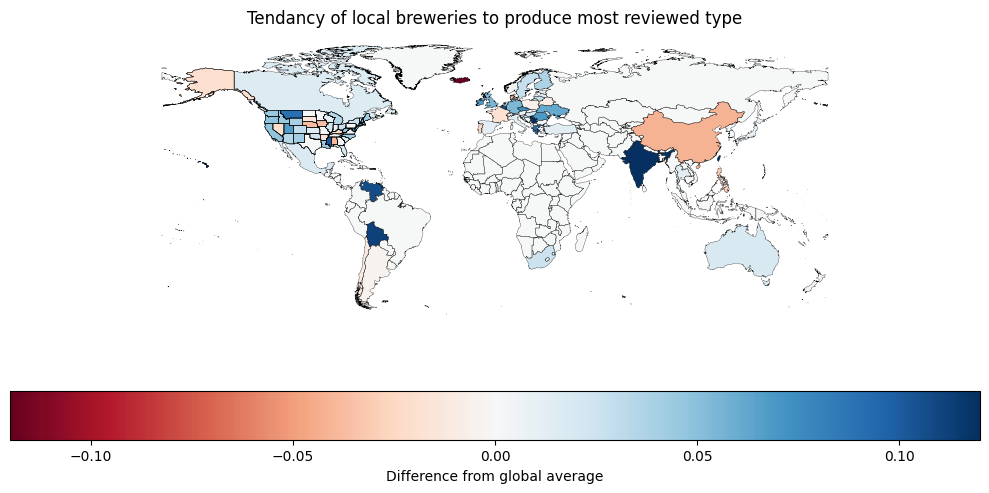

In [705]:
# color map
#color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sf_local_breweries2.boundary.plot(ax=ax, linewidth=.2, color='black')
#sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
#_ =shiftedColorMap(plt.get_cmap('seismic'), -0.1, 0.28, 0.6, name='test_2')

sf_local_breweries2.plot(column='diff', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Difference from global average", "orientation": "horizontal"}, vmin=-0.12, vmax=0.12)
#cbar=m.colorbar(location="bottom")
"""divnorm=colors.TwoSlopeNorm(vmin=-0.1, vcenter=0., vmax=0.6)
pcolormesh(your_data, cmap="coolwarm", norm=divnorm)"""
#pcm = ax.pcolormesh(sf_local_breweries, vmin=-1., vmax=1., cmap='RdBu_r')
plt.title('Tendancy of local breweries to produce most reviewed type')
plt.axis('off')
plt.tight_layout()
plt.savefig('../results/map_local_breweries_most_reviewed.png')
plt.show()

# Check for each country, what is the main country provider

# code here

# OLD STUFF

The first part of the analysis is to find the main predictor for each country

In [352]:
from utils import *
import numpy as np
import statsmodels.api as sm

# REDUCED = None
REDUCED = 2e5

# Preprocessed ratings 
preprocessed_ratings_ba = load_data("pre_ba", REDUCED)
preprocessed_ratings_ba['same_country'] = (preprocessed_ratings_ba['user_location'] == preprocessed_ratings_ba['brewery_location']).astype(int)


FileNotFoundError: [Errno 2] No such file or directory: '../data/preprocessed/BeerAdvocate/preprocessed_ratings_ba.csv.zip'

In [15]:
preprocessed_ratings_ba = pd.get_dummies(preprocessed_ratings_ba,columns=['style', 'user_location', 'brewery_location'], dtype='int')

In [16]:
columns_of_interest = ['abv','same_country']
columns_of_interest += [col for col in preprocessed_ratings_ba.columns if ('style_' in col or 'location_' in col)] 

In [17]:
X = preprocessed_ratings_ba[columns_of_interest]  # Predictors
y = preprocessed_ratings_ba['zscore']             # Target variable
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 zscore   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     144.0
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:47:40   Log-Likelihood:            -2.5299e+05
No. Observations:              200000   AIC:                         5.065e+05
Df Residuals:                  199738   BIC:                         5.092e+05
Df Model:                         261                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process = (data_to_process - data_to_process.mean()) / data_to_process.std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

# Merge the datasets using the "user_id" column
merged_data = pd.merge(ratings_ba, users_ba[['user_id', 'location']], on='user_id', how='inner')

# Create an empty DataFrame to store regression results
results = pd.DataFrame(columns=['country', 'main_predictor'])

# Define the columns of interest (predictors)
columns_of_interest = ["appearance", "aroma", "palate", "taste", "overall"]

# Loop through each country and perform linear regression
for country in merged_data['location'].unique():
    country_data = merged_data[merged_data['location'] == country]
    try:
        res=get_LR(country_data, columns_of_interest)
        main_predictor = res.params.idxmax()  # Get the main predictor with the highest coefficient
        results = pd.concat([results, pd.DataFrame({'country': [country], 'main_predictor': [main_predictor]})], ignore_index=True)
    except:
        pass



# Load a world shapefile for mapping (you may need to download a suitable shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world shapefile with the results DataFrame
world = world.merge(results, left_on='name', right_on='country', how='left')

# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='main_predictor', cmap='coolwarm', ax=ax, legend=True)
plt.title('Main Predictor by Country')
plt.show()
